In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import datetime
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import optuna
import eli5
from eli5.sklearn import PermutationImportance
import pickle
import warnings
warnings.simplefilter("ignore")

dataset - данные с гитхаб (сбор с банки.ру)

dataset_3 - мэтчинг номера лицензии банка с его названием

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df2 = pd.read_excel('dataset_3.xlsx', engine='openpyxl')

In [4]:
df2 = df2[['Lic', 'fact', 'date']]
df2['date'] = df2['date'].dt.to_period('M')
df = df.sort_values(by=['дата', 'лицензия'])
df['дата'] = pd.to_datetime(df['дата']).dt.to_period('M')

for i in tqdm(range(len(df))):
    tmp1 = df.iloc[i, 0]
    tmp2 = df.iloc[i, 1]
    try:
        a = df2.loc[(df2['Lic']==tmp1)&(df2['date']==tmp2+3), 'fact'].values[0]
        df.iloc[i, -1] = a
    except:
        try:
            a = df2.loc[(df2['Lic']==tmp1)&(df2['date']==tmp2+2), 'fact'].values[0]
            df.iloc[i, -1] = a
        except:
            try:
                a = df2.loc[(df2['Lic']==tmp1)&(df2['date']==tmp2+1), 'fact'].values[0]
                df.iloc[i, -1] = a
            except:
                df.iloc[i, -1] = 0

df = df[df['лицензия'].isna()==False]
df.drop_duplicates(subset=['лицензия', 'дата'], inplace=True)

100%|██████████| 72439/72439 [03:51<00:00, 313.35it/s]


In [19]:
df['default'].value_counts()

default
0.0       69285
отозв.      807
ликв.       127
Name: count, dtype: int64

In [20]:
df.to_csv('dataset_1.csv')

In [38]:
df = df.sort_values(by=['дата', 'лицензия'])
df['дата'] = pd.to_datetime(df['дата']).dt.to_period('M')

target = []

for i in tqdm(range(len(df))):
    tmp1 = df.iloc[i, 0]
    tmp2 = df.iloc[i, 1]
    try:
        res = df.loc[(df['лицензия']==tmp1)&(df['дата']==tmp2+12), 'default'].values[0]
        target.append(res)
    except:
        target.append(np.nan)

df['target'] = target

100%|██████████| 22627/22627 [00:14<00:00, 1523.11it/s]


In [44]:
df = df[df['target'].isna()==False]
df.drop('default', axis=1, inplace=True)

In [45]:
df.to_csv('dataset_1.csv')

In [89]:
oot = df[df['дата'] >= '2016-07']
train = df[df['дата'] < '2016-07']

In [66]:
oot

,лицензия,дата,net_assets,ROA,liquid,ibl,stocks,bond,oth_cap,sunk_retail_credit,...,micex_return,net_foreign_assets_diff,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff,target
98,1.0,2016-07,1.299388e+09,67.0,45302724.0,265735725.0,115820.0,99992446.0,1230104.0,16211658.0,...,-0.004079,231336.0,-118978.0,1064354.0,-34891.883750,-145143.0,-0.13,-0.009408,-0.424110,0.0
193,2.0,2016-07,2.654495e+06,69.0,581725.0,1.0,0.0,0.0,0.0,12069.0,...,-0.004079,231336.0,-118978.0,1064354.0,-34891.883750,-145143.0,-0.13,-0.009408,-0.424110,0.0
407,21.0,2016-07,1.266666e+06,-26.0,170612.0,540344.0,0.0,0.0,0.0,14533.0,...,-0.004079,231336.0,-118978.0,1064354.0,-34891.883750,-145143.0,-0.13,-0.009408,-0.424110,0.0
568,52.0,2016-07,8.799266e+06,-231.0,1572534.0,1200000.0,0.0,0.0,94.0,67425.0,...,0.030324,-453595.0,-343222.0,-90632.0,-79837.561630,-9974.0,-0.22,0.027048,-0.306190,0.0
662,53.0,2016-07,1.432703e+07,41.0,687171.0,2951611.0,0.0,4116081.0,0.0,108612.0,...,0.030324,-453595.0,-343222.0,-90632.0,-79837.561630,-9974.0,-0.22,0.027048,-0.306190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71761,3470.0,2016-12,1.707625e+06,-3799.0,172580.0,0.0,0.0,0.0,0.0,0.0,...,-0.004994,-667571.0,285513.0,-82.0,-91509.480620,30725.0,0.38,-0.012657,0.330301,0.0
71966,3473.0,2016-12,2.037870e+05,3469.0,113844.0,0.0,0.0,0.0,0.0,0.0,...,-0.107961,436060.0,255770.0,-14319.0,399.256384,31116.0,2.09,0.027083,1.851500,0.0
72091,3475.0,2016-12,7.102886e+06,421.0,40595.0,3638560.0,0.0,0.0,0.0,0.0,...,0.001803,-441720.0,2541323.0,-84154.0,89040.693140,463662.0,-25.94,0.027483,-0.340802,0.0
72293,3479.0,2016-12,1.879150e+05,792.0,182235.0,0.0,0.0,60466.0,0.0,0.0,...,0.037472,1544072.0,-279237.0,72341.0,51129.018000,991300.0,-0.28,0.031083,-0.161429,0.0


In [64]:
oot.target.mean()

0.0038031851675778463

In [94]:
df_1 = train.loc[train['target']==1]
df_1 = df_1.loc[df_1.index.repeat(10)]
train_n = pd.concat([train.loc[train['target']==0], df_1]).sample(frac=1, random_state=42)

In [82]:
DC = DecisionTreeClassifier(max_depth=10)
DC.fit(X_train, y_train)
roc_auc_score(y_valid, DC.predict_proba(X_valid)[:,1])

0.4975745385707525

In [95]:
X_train, X_valid, y_train, y_valid = train_test_split(train_n.drop(['target', 'лицензия', 'дата'], axis=1), train_n.target, test_size=0.2, random_state=42)

0.09915544152234324


# Main

## Model Finance

In [6]:
df_main = pd.read_excel('rating_dataset.xlsx', engine='openpyxl')
df_main.sort_values(['company', 'date'], inplace=True)
df_main['default'] = df_main['default'].replace({'отозв.': 1, 'ликв.': 1}).astype(float)

# Сброс индекса
df_main.reset_index(drop=True, inplace=True)

# Создание маски для ситуаций, когда в предыдущей строке было 1, а в следующей 0
mask = (df_main['default'].diff() == -1)

# Создание маски для ситуаций, когда компания в следующей строке такая же, как в предыдущей
same_company = df_main['company'] == df_main['company'].shift()

# Выбор строк, где обе маски истинны
result = df_main[mask & same_company]
df_main = df_main.drop(result.index)

df_main.sort_values(['company', 'date'], inplace=True)
df_main.reset_index(drop=True, inplace=True)

In [7]:
df_main_finance = df_main[['date', 'company', 'number', 'net_assets', 'ROA', 'liquid', 'ibl',
       'stocks', 'bond', 'oth_cap', 'sunk_retail_credit', 'NI',
       'organization_credit', 'sunk_organization_credit', 'credit_portf',
       'sunk_credit_portf', 'organization_deposit', 'retail_deposit',
       'security_tot', 'ROE', 'retail_credit', 'reserv_credit_perc',
       'zalog_credit_perc', 'foreign_na_fr', 'retail_deposit_fr', 'N3', 'N2',
       'N1', 'capital', 'msk_spb', 'INF_SA', 'NX_growth', 'micex_std',
       'miacr_std', 'miacr_amount', 'usd_rub_std_diff', 'micex_return',
       'net_foreign_assets_diff', 'net_gov_debt_diff', 'other_fin_debt_diff',
       'retail_debt_SA_DETREND_diff', 'stocks_capital_diff',
       'i_retail_spread_diff', 'usd_rub_return', 'miacr_diff', 'default']]
df_main_finance

,date,company,number,net_assets,ROA,liquid,ibl,stocks,bond,oth_cap,...,micex_return,net_foreign_assets_diff,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff,default
0,2015-01,АБСОЛЮТ БАНК,2306,370418,10.0,58863,20000,30475,0,0,...,-0.089597,185406,-440947,-36031,-8887.344990,65787,-0.10,-0.005332,0.515381,0.0
1,2015-02,АБСОЛЮТ БАНК,2306,363469,7.0,72211,0,30185,0,0,...,0.010585,228442,-202608,30484,8259.556338,9502,-0.40,0.001893,-0.023000,0.0
2,2015-03,АБСОЛЮТ БАНК,2306,378015,28.0,71270,0,24988,0,0,...,0.036272,160727,-367349,24070,-28573.126250,-6898,0.60,-0.002676,0.138571,0.0
3,2015-04,АБСОЛЮТ БАНК,2306,480085,24.0,66992,90000,33632,0,0,...,-0.115092,-4835,-452575,26026,5921.527527,82901,0.00,0.029888,0.088820,0.0
4,2015-05,АБСОЛЮТ БАНК,2306,505272,-86.0,76423,80000,29152,0,0,...,-0.030290,956039,-368635,258,2741.964361,-46226,-0.30,0.063494,0.496245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7620,2017-08,ЮНИСТРИМ,3467,616737,268.0,73695,0,0,0,0,...,0.039273,-203186,-290359,54033,-59543.722580,131802,-0.80,-0.015411,-0.191263,0.0
7621,2017-09,ЮНИСТРИМ,3467,712326,349.0,16500,113000,0,0,0,...,-0.006700,-95412,-373974,9337,16513.035910,90175,0.30,0.018529,0.145739,0.0
7622,2017-10,ЮНИСТРИМ,3467,727700,434.0,140433,0,0,0,0,...,-0.013265,326241,14751,75921,-28509.633280,5418,-0.90,0.005711,0.193273,0.0
7623,2017-11,ЮНИСТРИМ,3467,725101,1106.0,102891,0,0,0,0,...,0.001803,-441720,2541323,-84154,89040.693140,463662,-25.94,0.027483,-0.340802,0.0


In [8]:
oot = df_main_finance[df_main_finance['date'] >= '2017-05']
train = df_main_finance[df_main_finance['date'] < '2017-05']
print(oot.default.mean(), train.default.mean())

0.014164305949008499 0.023301858056655498


In [9]:
check = train[train['date'] >= '2017-02']
check.default.mean()

0.022044088176352707

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['date', 'company', 'number', 'default'], axis=1),
                                                  train.default,
                                                  test_size=0.2,
                                                  random_state=42)

In [12]:
DC = DecisionTreeClassifier(max_depth=6, random_state=42)
DC.fit(X_train, y_train)
roc_auc_score(y_val, DC.predict_proba(X_val)[:,1])

0.5286094365675411

In [13]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(verbose=False, random_state=42, l2_leaf_reg=10)
cb.fit(X_train, y_train, eval_set=(X_val, y_val))
print(2*roc_auc_score(oot.default, cb.predict_proba(oot[X_train.columns])[:,1])-1)

0.28825031928480227


In [43]:
def objective(trial):
    params = {
        "iterations": 1500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_state": 42
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_val)
    gini = 2*roc_auc_score(y_val, predictions[:, 1])-1
    return gini

In [44]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-03-18 20:54:09,110] A new study created in memory with name: no-name-9635852a-e457-4199-b5fb-83e8fd61271c
[I 2024-03-18 20:54:13,403] Trial 0 finished with value: 0.48984609167143756 and parameters: {'learning_rate': 0.014823625633170311, 'depth': 4, 'l2_leaf_reg': 5, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.48984609167143756.
[I 2024-03-18 20:54:17,511] Trial 1 finished with value: 0.739534570437477 and parameters: {'learning_rate': 0.056131962448780603, 'depth': 4, 'l2_leaf_reg': 2, 'min_data_in_leaf': 57}. Best is trial 1 with value: 0.739534570437477.
[I 2024-03-18 20:54:21,681] Trial 2 finished with value: 0.30077796113562116 and parameters: {'learning_rate': 0.007186475736462427, 'depth': 4, 'l2_leaf_reg': 7, 'min_data_in_leaf': 45}. Best is trial 1 with value: 0.739534570437477.
[I 2024-03-18 20:54:31,443] Trial 3 finished with value: 0.5745798673087934 and parameters: {'learning_rate': 0.018388656399111095, 'depth': 7, 'l2_leaf_reg': 8, 'min_data_in_leaf':

In [45]:
print('Best hyperparameters:', study.best_params)
print('Best GINI:', study.best_value)

Best hyperparameters: {'learning_rate': 0.09237576047861393, 'depth': 9, 'l2_leaf_reg': 3, 'min_data_in_leaf': 85}
Best GINI: 0.7839894924729733


In [46]:
cb = CatBoostClassifier(**study.best_params, random_state=42, verbose=False)
cb.fit(X_train, y_train, eval_set=(X_val, y_val))
print(f'GINI on TRAIN: {2*roc_auc_score(y_train, cb.predict_proba(X_train)[:, 1])-1}')
print(f'GINI on VAL: {2*roc_auc_score(y_val, cb.predict_proba(X_val)[:, 1])-1}')
print(f'GINI on OOT: {2*roc_auc_score(oot.default.astype(int), cb.predict_proba(oot[X_train.columns])[:, 1])-1}')

GINI on TRAIN: 1.0
GINI on VAL: 0.7625703027649613
GINI on OOT: 0.24022988505747112


In [28]:
perm = PermutationImportance(cb, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0084 ± 0.0014,sunk_retail_credit
0.0072 ± 0.0014,sunk_organization_credit
0.0071 ± 0.0017,N3
0.0070 ± 0.0022,liquid
0.0062 ± 0.0018,NI
0.0059 ± 0.0016,retail_deposit
0.0051 ± 0.0014,sunk_credit_portf
0.0047 ± 0.0013,security_tot
0.0043 ± 0.0007,capital
0.0042 ± 0.0005,net_assets


In [32]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(train.drop(['default', 'date', 'company', 'number'], axis=1), train.default)

predict_proba = xgb_clf.predict_proba(oot.drop(['default', 'date', 'company', 'number'], axis = 1))
predict = xgb_clf.predict(oot.drop(['default', 'date', 'company', 'number'], axis = 1))
print(2*roc_auc_score(oot.default, predict_proba[:,1]) -1 )
print(f'GINI on TRAIN: {2*roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])-1}')
print(f'GINI on VAL: {2*roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])-1}')
print(f'GINI on OOT: {2*roc_auc_score(oot.default.astype(int), xgb_clf.predict_proba(oot[X_train.columns])[:, 1])-1}')

0.47867177522349946
GINI on TRAIN: 1.0
GINI on VAL: 1.0
GINI on OOT: 0.47867177522349946


In [37]:
def objective2(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42
    }

    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    y_pred = optuna_model.predict_proba(X_val)

    gini = 2*roc_auc_score(y_val, y_pred[:, 1])-1
    return gini

In [38]:
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective2, n_trials=30)

[I 2024-03-18 20:50:50,418] A new study created in memory with name: no-name-01b147e6-8777-48c1-8fbb-3f5ec7754e6a
[I 2024-03-18 20:50:50,535] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 1, 'learning_rate': 0.595525876698069, 'n_estimators': 57, 'min_child_weight': 10, 'gamma': 1.6245928686236723e-07, 'subsample': 0.012456538947147856, 'colsample_bytree': 0.02190337350311775, 'reg_alpha': 9.211471893544367e-06, 'reg_lambda': 0.0008771035846125621}. Best is trial 0 with value: 0.0.
[I 2024-03-18 20:50:50,838] Trial 1 finished with value: 0.04960765163506564 and parameters: {'max_depth': 1, 'learning_rate': 0.0273360288578864, 'n_estimators': 383, 'min_child_weight': 9, 'gamma': 2.2109698632889016e-05, 'subsample': 0.05383244905001639, 'colsample_bytree': 0.4786773568310822, 'reg_alpha': 0.023829023794646027, 'reg_lambda': 0.5729320527992533}. Best is trial 1 with value: 0.04960765163506564.
[I 2024-03-18 20:50:51,124] Trial 2 finished with value: 0.09897955747145781 an

In [39]:
print('Best hyperparameters:', study2.best_params)
print('Best GINI:', study2.best_value)

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.10433538966177278, 'n_estimators': 477, 'min_child_weight': 1, 'gamma': 0.3873847660697927, 'subsample': 0.7615000914800703, 'colsample_bytree': 0.07137312556916636, 'reg_alpha': 0.0012821576843089085, 'reg_lambda': 5.879128319765788e-06}
Best GINI: 0.6422725894992085


In [40]:
xgb_clf = XGBClassifier(**study2.best_params)
xgb_clf.fit(X_train, y_train)
print(f'GINI on TRAIN: {2*roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])-1}')
print(f'GINI on VAL: {2*roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])-1}')
print(f'GINI on OOT: {2*roc_auc_score(oot.default.astype(int), xgb_clf.predict_proba(oot[X_train.columns])[:, 1])-1}')

GINI on TRAIN: 1.0
GINI on VAL: 0.5539689489105177
GINI on OOT: 0.28212005108556837


In [48]:
importances = cb.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.DataFrame({'Value': importances, 'Feature': X_train.columns}).sort_values(by='Value', ascending=False)
feature_importances_list = feature_importances.loc[feature_importances['Value'] > 1, 'Feature'].values
feature_importances_list, len(feature_importances_list)

(array(['liquid', 'NI', 'sunk_retail_credit', 'ibl',
        'sunk_organization_credit', 'N3', 'organization_credit', 'ROE',
        'miacr_std', 'capital', 'sunk_credit_portf',
        'organization_deposit', 'ROA', 'retail_deposit', 'INF_SA',
        'micex_std', 'miacr_amount', 'msk_spb', 'net_assets',
        'credit_portf', 'stocks', 'NX_growth', 'usd_rub_return', 'bond',
        'security_tot', 'oth_cap', 'retail_debt_SA_DETREND_diff',
        'stocks_capital_diff', 'usd_rub_std_diff', 'micex_return',
        'other_fin_debt_diff', 'net_foreign_assets_diff',
        'i_retail_spread_diff', 'net_gov_debt_diff', 'foreign_na_fr',
        'miacr_diff'], dtype=object),
 36)

In [49]:
def objective3(trial):
    params = {
        "iterations": 1500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_state": 42
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(X_train[feature_importances_list[:20]], y_train)
    predictions = model.predict_proba(X_val[feature_importances_list[:20]])
    gini = 2*roc_auc_score(y_val, predictions[:, 1])-1
    return gini 

In [50]:
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective3, n_trials=30)

[I 2024-03-18 21:05:36,815] A new study created in memory with name: no-name-2e16ae6d-18bc-427a-a6b1-11cc9fe130d1
[I 2024-03-18 21:05:45,005] Trial 0 finished with value: 0.45266561142356787 and parameters: {'learning_rate': 0.0037193590589404504, 'depth': 6, 'min_data_in_leaf': 39}. Best is trial 0 with value: 0.45266561142356787.
[I 2024-03-18 21:05:49,597] Trial 1 finished with value: 0.44680564442797954 and parameters: {'learning_rate': 0.035747485629043986, 'depth': 2, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.45266561142356787.
[I 2024-03-18 21:05:56,788] Trial 2 finished with value: 0.6048226854814265 and parameters: {'learning_rate': 0.012848006767483083, 'depth': 5, 'min_data_in_leaf': 57}. Best is trial 2 with value: 0.6048226854814265.
[I 2024-03-18 21:06:13,178] Trial 3 finished with value: 0.7567776917118514 and parameters: {'learning_rate': 0.036813583712041846, 'depth': 8, 'min_data_in_leaf': 80}. Best is trial 3 with value: 0.7567776917118514.
[I 2024-03-18

In [51]:
cb = CatBoostClassifier(**study3.best_params, random_state=42, verbose=False)
cb.fit(X_train, y_train, eval_set=(X_val, y_val))
print(f'GINI on TRAIN: {2*roc_auc_score(y_train, cb.predict_proba(X_train)[:, 1])-1}')
print(f'GINI on VAL: {2*roc_auc_score(y_val, cb.predict_proba(X_val)[:, 1])-1}')
print(f'GINI on OOT: {2*roc_auc_score(oot.default.astype(int), cb.predict_proba(oot[X_train.columns])[:, 1])-1}')

GINI on TRAIN: 1.0
GINI on VAL: 0.7155558549152998
GINI on OOT: 0.17330779054916978


In [52]:
print('Best hyperparameters:', study3.best_params)
print('Best GINI:', study3.best_value)

Best hyperparameters: {'learning_rate': 0.06669890972268486, 'depth': 9, 'min_data_in_leaf': 92}
Best GINI: 0.8034553598491228


In [107]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 130, number of negative: 5122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8029
[LightGBM] [Info] Number of data points in the train set: 5252, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024752 -> initscore=-3.673766
[LightGBM] [Info] Start training from score -3.673766


LGBMClassifier()

In [111]:
print(2*roc_auc_score(oot.default, clf.predict_proba(oot[X_train.columns])[:,1])-1)

0.6019937358973495


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 14)
    plt.yticks(tick_marks, classes, fontsize = 14)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=25)

    plt.tight_layout()
    plt.ylabel('Реальное значение целевой переменной', fontsize = 16)
    plt.xlabel('Предсказанное значение целевой переменной', fontsize = 16)

In [ ]:
from sklearn.isotonic import IsotonicRegression
isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(prb, oot.default.astype(int)) 
prb_isotonic_regress = isotonic_regress.predict_proba(clf.predict(oot[X_train.columns])[:, 1])

# Model Ratings

In [77]:
df_main

,Unnamed: 0,date,company,rating_AKM_rus,rating_exra_rus,rating_fitch_long,rating_fitch_rus,rating_moody_long,rating_moody_rus,rating_NRA_rus,...,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff,default,rating_AKM_rus_shift_1,rating_AKM_rus_shift_3,rating_AKM_rus_shift_6,rating_AKM_rus_shift_12
0,0,2015-01,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,...,-8887.344990,65787,-0.10,-0.005332,0.515381,0.0,NaN,NaN,NaN,NaN
1,293,2015-02,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,...,8259.556338,9502,-0.40,0.001893,-0.023000,0.0,NaN,NaN,NaN,NaN
2,584,2015-03,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,...,-28573.126250,-6898,0.60,-0.002676,0.138571,0.0,NaN,NaN,NaN,NaN
3,875,2015-04,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,...,5921.527527,82901,0.00,0.029888,0.088820,0.0,NaN,NaN,NaN,NaN
4,1162,2015-05,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,...,2741.964361,-46226,-0.30,0.063494,0.496245,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7620,7172,2017-08,ЮНИСТРИМ,NaN,(ruBBB+),NaN,NaN,NaN,NaN,NaN,...,-59543.722580,131802,-0.80,-0.015411,-0.191263,0.0,NaN,NaN,NaN,NaN
7621,7294,2017-09,ЮНИСТРИМ,NaN,(ruBBB+),NaN,NaN,NaN,NaN,NaN,...,16513.035910,90175,0.30,0.018529,0.145739,0.0,NaN,NaN,NaN,NaN
7622,7415,2017-10,ЮНИСТРИМ,NaN,(ruBBB+),NaN,NaN,NaN,NaN,NaN,...,-28509.633280,5418,-0.90,0.005711,0.193273,0.0,NaN,NaN,NaN,NaN
7623,7536,2017-11,ЮНИСТРИМ,NaN,(ruBBB+),NaN,NaN,NaN,NaN,NaN,...,89040.693140,463662,-25.94,0.027483,-0.340802,0.0,NaN,NaN,NaN,NaN


In [75]:
cols_rating = ['rating_AKM_rus', 'rating_exra_rus',
       'rating_fitch_long', 'rating_fitch_rus', 'rating_moody_long',
       'rating_moody_rus', 'rating_NRA_rus', 'rating_rusrate',
       'rating_rusrate_rus', 'rating_sp_long', 'rating_sp_rus',
       'rating_sp_short']

In [76]:
for col in cols_rating:
    df_main[col + '_shift_1'] = df_main.groupby('company')[col].shift(1)
    df_main[col + '_shift_3'] = df_main.groupby('company')[col].shift(3)
    df_main[col + '_shift_6'] = df_main.groupby('company')[col].shift(6)
    df_main[col + '_shift_12'] = df_main.groupby('company')[col].shift(12)
    df_main[col + '_diff_1'] = df_main.groupby('company')[col].diff(1)
    df_main[col + '_diff_3'] = df_main.groupby('company')[col].diff(3)
    df_main[col + '_diff_6'] = df_main.groupby('company')[col].diff(6)
    df_main[col + '_diff_12'] = df_main.groupby('company')[col].diff(12)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
cols_rating_new = ['rating_AKM_rus', 'rating_exra_rus',
       'rating_fitch_long', 'rating_fitch_rus', 'rating_moody_long',
       'rating_moody_rus', 'rating_NRA_rus', 'rating_rusrate',
       'rating_rusrate_rus', 'rating_sp_long', 'rating_sp_rus',
       'rating_sp_short', 'rating_AKM_rus_shift_1', 'rating_AKM_rus_shift_3', 'rating_AKM_rus_shift_6', 'rating_AKM_rus_shift_12', 'rating_AKM_rus_diff_1', 'rating_AKM_rus_diff_3', 'rating_AKM_rus_diff_6', 'rating_AKM_rus_diff_12', 'rating_exra_rus_shift_1', 'rating_exra_rus_shift_3', 'rating_exra_rus_shift_6', 'rating_exra_rus_shift_12', 'rating_exra_rus_diff_1', 'rating_exra_rus_diff_3', 'rating_exra_rus_diff_6', 'rating_exra_rus_diff_12', 'rating_fitch_long_shift_1', 'rating_fitch_long_shift_3', 'rating_fitch_long_shift_6', 'rating_fitch_long_shift_12', 'rating_fitch_long_diff_1', 'rating_fitch_long_diff_3', 'rating_fitch_long_diff_6', 'rating_fitch_long_diff_12', 'rating_fitch_rus_shift_1', 'rating_fitch_rus_shift_3', 'rating_fitch_rus_shift_6', 'rating_fitch_rus_shift_12', 'rating_fitch_rus_diff_1', 'rating_fitch_rus_diff_3', 'rating_fitch_rus_diff_6', 'rating_fitch_rus_diff_12', 'rating_moody_long_shift_1', 'rating_moody_long_shift_3', 'rating_moody_long_shift_6', 'rating_moody_long_shift_12', 'rating_moody_long_diff_1', 'rating_moody_long_diff_3', 'rating_moody_long_diff_6', 'rating_moody_long_diff_12', 'rating_moody_rus_shift_1', 'rating_moody_rus_shift_3', 'rating_moody_rus_shift_6', 'rating_moody_rus_shift_12', 'rating_moody_rus_diff_1', 'rating_moody_rus_diff_3', 'rating_moody_rus_diff_6', 'rating_moody_rus_diff_12', 'rating_NRA_rus_shift_1', 'rating_NRA_rus_shift_3', 'rating_NRA_rus_shift_6', 'rating_NRA_rus_shift_12', 'rating_NRA_rus_diff_1', 'rating_NRA_rus_diff_3', 'rating_NRA_rus_diff_6', 'rating_NRA_rus_diff_12', 'rating_rusrate_shift_1', 'rating_rusrate_shift_3', 'rating_rusrate_shift_6', 'rating_rusrate_shift_12', 'rating_rusrate_diff_1', 'rating_rusrate_diff_3', 'rating_rusrate_diff_6', 'rating_rusrate_diff_12', 'rating_rusrate_rus_shift_1', 'rating_rusrate_rus_shift_3', 'rating_rusrate_rus_shift_6', 'rating_rusrate_rus_shift_12', 'rating_rusrate_rus_diff_1', 'rating_rusrate_rus_diff_3', 'rating_rusrate_rus_diff_6', 'rating_rusrate_rus_diff_12', 'rating_sp_long_shift_1', 'rating_sp_long_shift_3', 'rating_sp_long_shift_6', 'rating_sp_long_shift_12', 'rating_sp_long_diff_1', 'rating_sp_long_diff_3', 'rating_sp_long_diff_6', 'rating_sp_long_diff_12', 'rating_sp_rus_shift_1', 'rating_sp_rus_shift_3', 'rating_sp_rus_shift_6', 'rating_sp_rus_shift_12', 'rating_sp_rus_diff_1', 'rating_sp_rus_diff_3', 'rating_sp_rus_diff_6', 'rating_sp_rus_diff_12', 'rating_sp_short_shift_1', 'rating_sp_short_shift_3', 'rating_sp_short_shift_6', 'rating_sp_short_shift_12', 'rating_sp_short_diff_1', 'rating_sp_short_diff_3', 'rating_sp_short_diff_6', 'rating_sp_short_diff_12']


# Validation

In [3]:
df_main = pd.read_excel('rating_dataset.xlsx', engine='openpyxl')
df_main.sort_values(['company', 'date'], inplace=True)
df_main['default'] = df_main['default'].replace({'отозв.': 1, 'ликв.': 1}).astype(float)

# Сброс индекса
df_main.reset_index(drop=True, inplace=True)

# Создание маски для ситуаций, когда в предыдущей строке было 1, а в следующей 0
mask = (df_main['default'].diff() == -1)

# Создание маски для ситуаций, когда компания в следующей строке такая же, как в предыдущей
same_company = df_main['company'] == df_main['company'].shift()

# Выбор строк, где обе маски истинны
result = df_main[mask & same_company]
df_main = df_main.drop(result.index)

df_main.sort_values(['company', 'date'], inplace=True)
df_main.reset_index(drop=True, inplace=True)

In [8]:
cols_fin = ['net_assets', 'ROA', 'liquid', 'ibl',
       'stocks', 'bond', 'oth_cap', 'sunk_retail_credit', 'NI',
       'organization_credit', 'sunk_organization_credit', 'credit_portf',
       'sunk_credit_portf', 'organization_deposit', 'retail_deposit',
       'security_tot', 'ROE', 'retail_credit', 'reserv_credit_perc',
       'zalog_credit_perc', 'foreign_na_fr', 'retail_deposit_fr', 'N3', 'N2',
       'N1', 'capital', 'msk_spb', 'INF_SA', 'NX_growth', 'micex_std',
       'miacr_std', 'miacr_amount', 'usd_rub_std_diff', 'micex_return',
       'net_foreign_assets_diff', 'net_gov_debt_diff', 'other_fin_debt_diff',
       'retail_debt_SA_DETREND_diff', 'stocks_capital_diff',
       'i_retail_spread_diff', 'usd_rub_return', 'miacr_diff']

cols_rat = ['rating_AKM_rus', 'rating_exra_rus',
       'rating_fitch_long', 'rating_fitch_rus', 'rating_moody_long',
       'rating_moody_rus', 'rating_NRA_rus', 'rating_rusrate',
       'rating_rusrate_rus', 'rating_sp_long', 'rating_sp_rus',
       'rating_sp_short']

oot = df_main[df_main['date'] >= '2017-05']
train = df_main[df_main['date'] < '2017-05']

X_train, X_val, y_train, y_val = train_test_split(train.drop(['date', 'company', 'number', 'default'], axis=1),
                                                  train.default,
                                                  test_size=0.2,
                                                  random_state=42)

## Data

Данные для построения модели были взяты из открытых источников github, сайт ЦБ, сайт Банки.ру

Алгоритм формирования выборки исключает появление лика данных, тк данные за конец 2017 года используются только в качестве формирования таргета, а признаковое описание наблюдений затрагивает период представленный ниже. 

В силу количества и качества данных (рейтинговые данные доступны не за каждый временной промежуток и многие агентства не публиковали свои рейтинги после 2018-19гг) за целевую событие был взят факт отзыва или ликвидации лицензии у банка на горизонте 3 месяцев с момента предсказания

Бизнес-задача: формирование портфеля банков для дальнейших инвестиций, а также подсчет вероятности наступления целевого события у прогнозируемого банка. Для решения задачи была выбрана метрика ROC-AUC (GINI), которая ранжирует наблюдения по уверенности в наступлении целевого события, а также позволяет корректно оценить вероятности прогнозов после проведения калибровки. Нам достаточно выделить top-N банков, в которые можно сделать вложения. Кроме того, для дальнейшего выполнения задания необходимо оценить вероятности наступления целевых событий

In [9]:
print(f'Дата начала TRAIN периода: {train["date"].min()}')
print(f'Дата окончания TRAIN периода: {train["date"].max()}')
print(f'Дата начала OOT периода: {oot["date"].min()}')
print(f'Дата окончания OOT периода: {oot["date"].max()}')

Дата начала TRAIN периода: 2015-01
Дата окончания TRAIN периода: 2017-04
Дата начала OOT периода: 2017-05
Дата окончания OOT периода: 2017-12


In [10]:
print(f'Среднее значение целевой переменной на TRAIN выборке: {round(y_train.mean(), 4)}')
print(f'Среднее значение целевой переменной на VAL выборке: {round(y_val.mean(), 4)}')
print(f'Среднее значение целевой переменной на OOT выборке: {round(oot.default.mean(), 4)}')

Среднее значение целевой переменной на TRAIN выборке: 0.0248
Среднее значение целевой переменной на VAL выборке: 0.0175
Среднее значение целевой переменной на OOT выборке: 0.0142


In [11]:
print(f'Количество наблюдений в TRAIN выборке: {X_train.shape[0]}')
print(f'Количество наблюдений в VAL выборке: {X_val.shape[0]}')
print(f'Количество наблюдений в OOT выборке: {oot.shape[0]}')

Количество наблюдений в TRAIN выборке: 5252
Количество наблюдений в VAL выборке: 1314
Количество наблюдений в OOT выборке: 1059


In [13]:
print(f'Количество целевых событий в TRAIN выборке: {y_train.sum()}')
print(f'Количество целевых событий в VAL выборке: {y_val.sum()}')
print(f'Количество целевых событий в OOT выборке: {oot.default.sum()}')

Количество целевых событий в TRAIN выборке: 130.0
Количество целевых событий в VAL выборке: 23.0
Количество целевых событий в OOT выборке: 15.0


Text(0, 0.5, 'Target_rate')

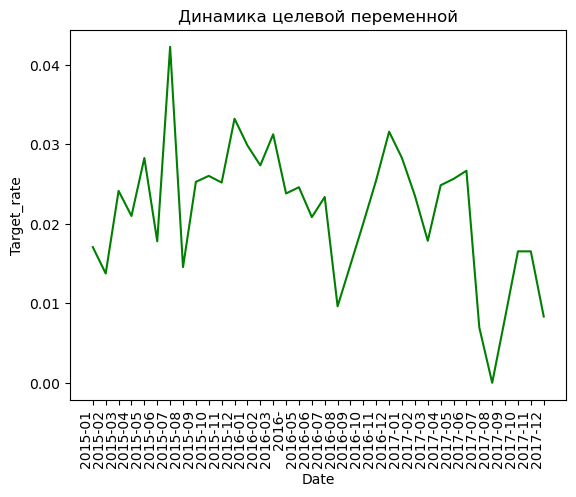

In [14]:
targets = df_main.sort_values(by='date').groupby('date')['default'].agg('mean').values
dates = ['2015-01', '2015-02', '2015-03', '2015-04',
       '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-',
       '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12']

plt.plot(dates, targets, color='green')
plt.title('Динамика целевой переменной')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Date')
plt.ylabel('Target_rate')

## Metrics test

In [33]:
with open('model_fin.pkl', 'rb') as f:
    model1 = pickle.load(f)

In [ ]:
df_scores_rat = pd.read_excel('rating_dataset.xlsx', engine='openpyxl')

In [17]:
df_main['score_finance'] = model1.predict_proba(df_main[cols_fin])[:, 1]
df_main['score_ratings'] = df_scores_rat['scores']

OOT = df_main[df_main['date'] >= '2017-05']
TRAIN = df_main[df_main['date'] < '2017-05']

In [26]:
print(f'OOT ROC-AUC Finance: {roc_auc_score(OOT.default, OOT.score_finance)}')
print(f'OOT ROC-AUC Ratings: {roc_auc_score(OOT.default, OOT.score_ratings)}')

OOT ROC-AUC Finance: 0.7047892720306513


AttributeError: 'DataFrame' object has no attribute 'score_ratings'

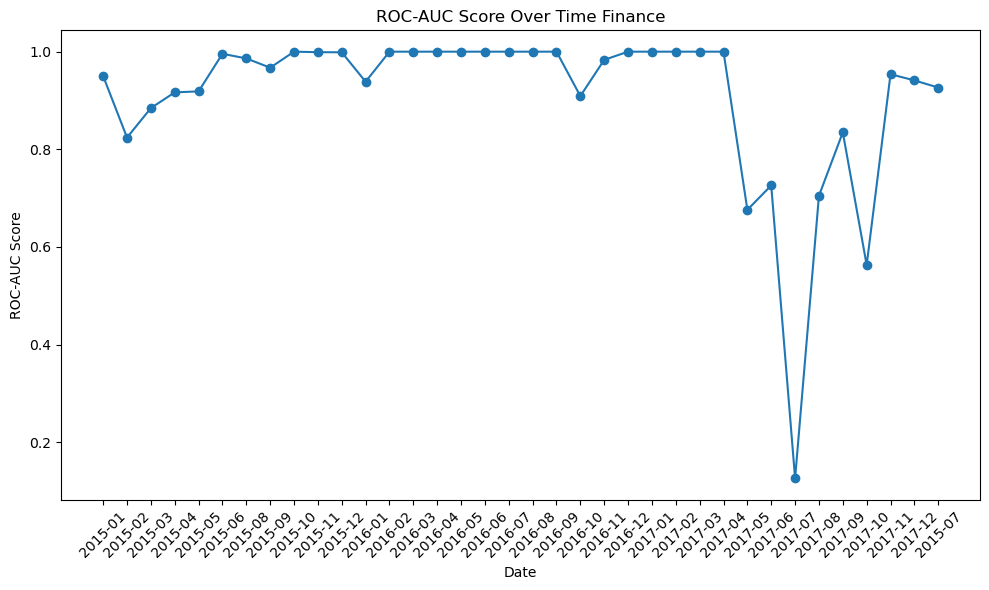

In [35]:
df_sorted = df_main.sort_values(by='date')

dates = df_main['date'].unique().tolist()
roc_auc_scores = []

for dt in dates:
    try:
        roc_auc = roc_auc_score(df_main[(df_main['date'] == dt)]['default'], df_main[df_main['date'] == dt]['score_finance'])
    except:
        roc_auc = roc_auc_score(OOT.default, OOT.score_finance)
    roc_auc_scores.append(roc_auc)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(dates, roc_auc_scores, marker='o')
plt.xlabel('Date')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score Over Time Finance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_sorted = df_main.sort_values(by='date')

dates = df_main['date'].unique().tolist()
roc_auc_scores = []

for dt in dates:
    try:
        roc_auc = roc_auc_score(df_main[(df_main['date'] == dt)]['default'], df_main[df_main['date'] == dt]['score_ratings'])
    except:
        roc_auc = roc_auc_score(OOT.default, OOT.score_finance)
    roc_auc_scores.append(roc_auc)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(dates, roc_auc_scores, marker='o')
plt.xlabel('Date')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score Over Time Finance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Metrics stability

## Calibration

За калибровочную функцию была взята логистическая регрессия, которая показала наилучший EXE (Expected Calibration Error)



Значение EXE у модели рейтингов получилось равным = 

Значение EXE у модели финансовых показателей получилось равным = 

(Расчеты представлены в ноутбуках по соответствующим моделям)